# CPSC 330 Lecture 22

Outline:

- Announcements
- Confidence, credence, and `predict_proba` (15 min)
- Credence activity (20 min)
- Break (5 min)
- Uncertainty in regression problems (15 min)
- Visualization videos recap (10 min)
- Visualization activity (25 min)

# TODO

this lecture takes too long. Perhaps the "Uncertainty in regression problems" can turn into its own separate lecture in the future.

Reminder to self: **turn on recording!**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
import load_process_data

In [13]:
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

## Announcements

- Per Piazza poll vote of 22-7, no breakout groups today.
- hw8 posted.
  - Deadline: Thurs April 9 at 6pm.
- This Friday, April 3, is the last day of tutorials.
- There are 2 more lectures including today; the last one is on Tuesday, April 7.
- Final exam is still April 24 from 12-2:30pm.
  - Tentative plan: similar to an assignment, open-book, but time-limited and no collaboration allowed.
  - Rationale: would do a reasonable job of testing the main points of the course; it would be harder to cheat than a closed-book exam.
- We have added 10 office hours during April 8-23; see the [calendar](https://www.cs.ubc.ca/~mgelbart/calendar.html).
  - These will take place on Collaborate Ultra.

## Attribution

- The first part of this lecture is adapted from [DSCI 542](https://github.com/UBC-MDS/DSCI_542_comm-arg), created by [David Laing](https://davidklaing.com/).
- The visualization component of this lecture benefitted from discussions with [Firas Moosvi](http://firas.moosvi.com/) about his course, [DSCI 531](https://github.com/UBC-MDS/DSCI_531_viz-1).

## Confidence and `predict_proba` (15 min)

- What does it mean to be "confident" in your results?
- When you perform analysis, you are responsible for many judgment calls.
- [Your results will be different than others'](https://fivethirtyeight.com/features/science-isnt-broken/#part1).
- As you make these judgments and start to form conclusions, how can you recognize your own uncertainties about the data so that you can communicate confidently?

#### What does this mean for us, when we're trying to make claims about our data?

Let's imagine that the following claim is true:

> Vancouver has the highest cost of living of all cities in Canada.

Now let's consider a few beliefs we could hold:

1. Vancouver has the highest cost of living of all cities in Canada. **I am 95% sure of this.** 
2. Vancouver has the highest cost of living of all cities in Canada. **I am 55% sure of this.** 

The part is bold is called a [credence](https://en.wikipedia.org/wiki/Credence_(statistics)). Which belief is better?

But what if it's actually Toronto that has the highest cost of living in Canada?

1. Vancouver has the highest cost of living of all cities in Canada. **I am 95% sure of this.** 
2. Vancouver has the highest cost of living of all cities in Canada. **I am 55% sure of this.** 

Which belief is better now?
<br><br><br><br><br><br>
Conclusion: We don't just want to be right. We want to be confident when we're right and hesitant when we're wrong.

#### What do credences mean in practical terms?

One of two things:

* **I would accept a bet at these odds.** 99% sure means, "For the chance of winning \\$1, I would bet \\$99 that I'm right about this." 75% sure means, "For the chance of winning \\$25, I would bet \\$75 that I'm right about this."
* **Long-run frequency of correctness.** 99% sure means, "For every 100 predictions I make at this level of confidence, I would expect only 1 of them to be incorrect." 75% sure means, "For every 100 predictions I make at this level of confidence, I would expect about 25 of them to be incorrect."

#### It's easy enough to evaluate how good we are at being right...

But if we want to evaluate *how good we are at knowing how right we are*?

We would need to keep of not just the correctness of our predictions, but also our confidence in those predictions.


#### What does this have to do with applied ML?

- What if you `predict` that a credit card transaction is fraudulent?
  - We probably want `predict_proba` a lot of the time.
- What if `predict_proba` is 0.95 in that case?
  - How confident are YOU?
- What if you forecast that avocado prices will go up next week? 
  - How confident are you there?
- Or what if you predict a house price to be \\$800k? 
  - That is not even a true/false statement.

#### Loss functions

When you call `fit` for `LogisticRegression` it has these same preferences: correct and confident > correct and hesitant > incorrect and hesitant > incorrect and confident.

In [ ]:
from sklearn.metrics import log_loss

- This is a "loss" or "error" function like mean squared error, so lower values are better.
- When you call `fit` it tries to minimize this metric.

Correct and 95% confident:

In [5]:
log_loss(y_true=np.array([0]), y_pred=np.array([[0.95, 0.05]]), labels=(0,1))

0.05129329438755058

Correct and 55% confident:

In [6]:
log_loss(y_true=np.array([0]), y_pred=np.array([[0.55, 0.45]]), labels=(0,1))

0.5978370007556204

Incorrect and 55% confident:

In [7]:
log_loss(y_true=np.array([0]), y_pred=np.array([[0.45, 0.55]]), labels=(0,1))

0.7985076962177716

Incorrect and 95% confident:

In [8]:
log_loss(y_true=np.array([0]), y_pred=np.array([[0.05, 0.95]]), labels=(0,1))

2.995732273553991

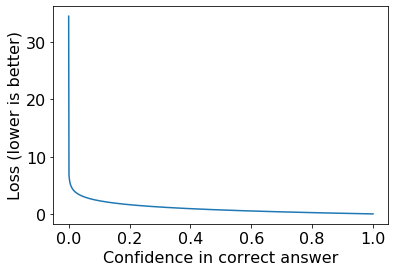

In [10]:
grid = np.linspace(0,1,1000)
plt.plot(grid, [log_loss(y_true=np.array([1]), y_pred=np.array([g]), labels=(0,1)) for g in grid]);
plt.xlabel("Confidence in correct answer");
plt.ylabel("Loss (lower is better)");

- Your loss goes to 0 as you approach 100% confidence in the correct answer.
- Your loss goes to infinity as you approach 100% confidence in the incorrect answer.
- (optional) See also the very related [How to assign partial credit on an exam of true-false questions?](https://terrytao.wordpress.com/2016/06/01/how-to-assign-partial-credit-on-an-exam-of-true-false-questions/).

The real `LogisticRegression` is averaging this score over all training examples.


Some nice examples: 

- [Scott Alexander](https://slatestarcodex.com/2019/01/22/2018-predictions-calibration-results/)
  - Look at how the plot starts at 50%.
  - That is because being 40% confident of "X" is the same as being 60% confident of "not X".
- [Good Judgment Project](https://www.gjopen.com/)





## Credence Activity (15 min)

Take 5 minutes and assign credences or values to the claims below, in the [Google Doc here](https://docs.google.com/document/d/17_bwAUNosoIWyrQonlNtzxVO6QCCrg1koeGKxknFNVo/edit?usp=sharing). 

**Do not Google the answers; the point of the exercise is to evaluate how good we are at guessing.** Also, please try not to be influenced by other peoples' answers!! 

* I am __ % sure that the world's tallest building is between 200m and 800m tall. 
* I am __ % sure that in 2018, the highest-grossing movie earned between \\$500 million and \\$1 billion worldwide while in theatres. 
* I am __ % sure that there are between 200 and 300 bones in an average adult human body. 
* I am __ % sure that the planet Mars is more massive than the planet Mercury. 
* I am 90% sure that the world's tallest tree taller than __ m.
* I am 80% sure that the world's tallest tree taller than __ m.
* I am 70% sure that the world's tallest tree taller than __ m.
* I am 60% sure that the world's tallest tree taller than __ m.
* I am 50% sure that the world's tallest tree taller than __ m.

NOTE: 0% means you are completely sure the statement is false, 100% means you are completely sure the statement is true.

Remember, your answers are 100% anonymous (or should I say I believe there's a 99.99% chance your answers are anonymous - maybe I am missing something!).

Afterwards, we'll discuss.

## Break (5 min)

## Uncertainty in regression problems (15 min)

For regression, we have not covered how to address the issue in this course.

In [14]:
def show_scores_housing(model, **fit_kwargs):
    model.fit(X_train_housing, y_train_housing_log, **fit_kwargs);
    return model.score(X_test_housing, y_test_housing_log)

In [15]:
X_train_housing, X_valid_housing, X_test_housing, \
y_train_housing, y_valid_housing, y_test_housing = load_process_data.load_housing(valid_split_random_state=1)

In [16]:
y_train_housing_log = np.log(y_train_housing)
y_valid_housing_log = np.log(y_valid_housing)
y_test_housing_log  = np.log(y_test_housing)

In [17]:
show_scores_housing(Ridge())

0.9305525539092756

In [18]:
show_scores_housing(RandomForestRegressor())

0.8761315724262819

In [19]:
show_scores_housing(xgb.XGBRegressor())

0.9089891134928475

In [20]:
show_scores_housing(lgb.LGBMRegressor())

0.9111783625488246

In [21]:
show_scores_housing(CatBoostRegressor(), verbose=0)

0.9282845151860312

Question: These look different from what we saw in lecture 20 - CatBoost was the best and now Ridge is the best. What happened?
<br><br><br><br><br><br>

Answer: I used a different train/validation split. So those results were probably not trustworthy. Should do cross-validation.

In [22]:
X_train_housing.shape

(1051, 291)

In [23]:
X_train_housing, X_test_housing, \
y_train_housing, y_test_housing = load_process_data.load_housing(split_valid=False)

In [24]:
y_train_housing_log = np.log(y_train_housing)
y_test_housing_log  = np.log(y_test_housing)

In [25]:
X_train_housing.shape

(1314, 297)

In [26]:
cv_ridge = cross_val_score(Ridge(), X_train_housing, y_train_housing_log, cv=5)
cv_ridge

array([0.87508178, 0.86071997, 0.88034875, 0.89238468, 0.73816936])

In [27]:
cv_rf = cross_val_score(RandomForestRegressor(), X_train_housing, y_train_housing_log, cv=5)
cv_rf

array([0.86932431, 0.83891181, 0.88117736, 0.87234991, 0.88354005])

In [28]:
cv_xgb = cross_val_score(xgb.XGBRegressor(), X_train_housing, y_train_housing_log, cv=5)
cv_xgb

array([0.8938605 , 0.85509363, 0.86350374, 0.85190166, 0.86195006])

In [29]:
cv_lgbm = cross_val_score(lgb.LGBMRegressor(), X_train_housing, y_train_housing_log, cv=5)
cv_lgbm

array([0.88360859, 0.86706822, 0.89511462, 0.88582816, 0.88985495])

In [30]:
cv_cat = cross_val_score(CatBoostRegressor(verbose=False), X_train_housing, y_train_housing_log, cv=5)
cv_cat

array([0.91402909, 0.89118846, 0.91271236, 0.90209736, 0.90602165])

In [31]:
cv_all = pd.DataFrame(np.array([cv_ridge, cv_rf, cv_xgb, cv_lgbm, cv_cat]).T, columns=["Ridge", "RF", "XGB", "LGBM", "Cat"])
cv_all

Ridge        RF       XGB      LGBM       Cat
0  0.875082  0.869324  0.893860  0.883609  0.914029
1  0.860720  0.838912  0.855094  0.867068  0.891188
2  0.880349  0.881177  0.863504  0.895115  0.912712
3  0.892385  0.872350  0.851902  0.885828  0.902097
4  0.738169  0.883540  0.861950  0.889855  0.906022

In [32]:
cv_all.mean(axis=0)

Ridge    0.849341
RF       0.869061
XGB      0.865262
LGBM     0.884295
Cat      0.905210
dtype: float64

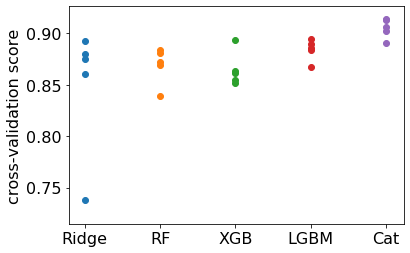

In [33]:
for i,col in enumerate(cv_all.columns):
    plt.scatter(0*cv_all[col]+i, cv_all[col], label=col);
plt.xticks(np.arange(cv_all.shape[1]), cv_all.columns);
plt.ylabel("cross-validation score");

# TODO

make a boxplot, especially if we had more folds?

- This paints a more accurate picture
- This also gives us a measure of our uncertainty. 
  - For Ridge, we could say $R^2\approx 0.85$ on the log targets, but it would be too confident to say $R^2= 0.85\pm 0.01$.
  - (In reality, we'd probably want to report the MAPE on the original prices when talking to stakeholders.)
- With classification (discrete outputs) we expressed uncertainty in terms of probabilities.
- With regression (continuous outputs), we express uncertainty in terms of _intervals_ or error bars. 

- And so far we've only looked at the different _scores_.
- We can also look at the _predictions_.
  - Then we can see a spread of predictions **even during deployment**.

#### Approaches to measure uncertainty

- Look at different cross-validation folds. 
  - This is similar to changing the random train/validation split.
  - Do **not** try different random train/test splits.
- [Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) as a general-purpose approach.
- Try different models and look at the predictions.
- If you are interested, read about [prediction intervals](https://en.wikipedia.org/wiki/Prediction_interval) and [quantile regression](https://en.wikipedia.org/wiki/Quantile_regression). See also [The difference between prediction intervals and confidence intervals](https://robjhyndman.com/hyndsight/intervals/).
  - It seems quantile regression has at least some support in sklearn, for example [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html).

#### Take-home messages

- Be aware of your confidence level in your claims.
  - You should present these to your stakeholders as well!
- Try to get a sense of the cost of different errors (as per lecture 8).

## Visualizing your results (5 min)

Pre-viewing review from [Calling BS visualization videos](https://www.youtube.com/watch?v=T-5aLbNeGo0&list=PLPnZfvKID1Sje5jWxt-4CSZD7bUI4gSPS&index=30&t=0s):

- Dataviz in the popular media.
  - e.g. [modern NYT](https://youtu.be/T-5aLbNeGo0?t=367)
- Misleading axes.
  - e.g. [vaccines](https://youtu.be/9pNWVMxaFuM?t=299)
- Manipulating bin sizes.
  - e.g. [tax dollars](https://youtu.be/zAg1wsYfwsM?t=196)
- Dataviz ducks.
  - e.g. [drinking water](https://youtu.be/rmii1hfP6d4?t=169)
  - "look how clever we are about design" -> making it about me instead of about you (lecture 21)
- Glass slippers.
  - e.g. [internet marketing tree](https://youtu.be/59teS0SUHtI?t=285)
- The principle of proportional ink.
  - e.g. [most read books](https://youtu.be/oNhusd3xFC4?t=147)

- [Demo of cleaning up a plot](https://www.darkhorseanalytics.com/blog/data-looks-better-naked)
- [Principle of proportional ink](https://serialmentor.com/dataviz/proportional-ink.html) from a viz textbook.

## Visualization activity (20 min)

Here's [a link to the housing dataset](https://www.kaggle.com/c/home-data-for-ml-course/) again.

In [37]:
X_train_housing, X_valid_housing, X_test_housing, \
y_train_housing, y_valid_housing, y_test_housing = load_process_data.load_housing(valid_split_random_state=1)

In [38]:
y_train_housing_log = np.log(y_train_housing)
y_valid_housing_log = np.log(y_valid_housing)
y_test_housing_log  = np.log(y_test_housing)

I totally forgot about this in lecture 20, but just remembered that sklearn also has a gradient boosted tree implemented:

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

Let's compare this to a random forest for different values of `n_estimators`.

In [35]:
n_estimators_values = [3, 10, 30, 100, 300]

In [36]:
score_rf_train = list()
score_rf_test = list()
score_gb_train = list()
score_gb_test = list()

for n_estimators in n_estimators_values:
    print(n_estimators)
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=123).fit(X_train_housing, y_train_housing_log)
    score_rf_train.append(rf.score(X_train_housing, y_train_housing_log))
    score_rf_test.append(rf.score(X_test_housing, y_test_housing_log))
    
    gb = GradientBoostingRegressor(n_estimators=n_estimators, random_state=123).fit(X_train_housing, y_train_housing_log)
    score_gb_train.append(gb.score(X_train_housing, y_train_housing_log))
    score_gb_test.append(gb.score(X_test_housing, y_test_housing_log))

3
10
30
100
300


Here is a low quality plot to get you thinking:

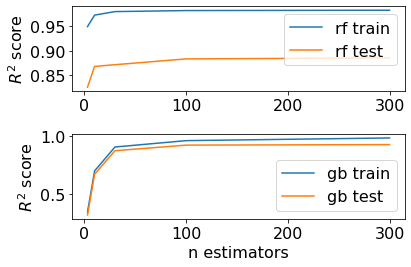

In [40]:
plt.subplot(2,1,1)
plt.plot(n_estimators_values, score_rf_train, label="rf train")
plt.plot(n_estimators_values, score_rf_test,  label="rf test")
plt.ylabel("$R^2$ score");
plt.legend();
plt.subplot(2,1,2)
plt.plot(n_estimators_values, score_gb_train, label="gb train")
plt.plot(n_estimators_values, score_gb_test,  label="gb test")
plt.xlabel("n estimators");
plt.ylabel("$R^2$ score");
plt.legend();
plt.tight_layout();

Your task is to do ONE (or more if you have time) of the following: 

- Create a visualization that makes RF look better than GB.
- Create a visualization that makes GB look better than RF.
- Create a visualization that makes RF and GB look equally good.

When you have a visualization, copy or screenshot it and paste it into the [Google Doc](https://docs.google.com/document/d/17_bwAUNosoIWyrQonlNtzxVO6QCCrg1koeGKxknFNVo/edit?usp=sharing).

Below are my plots made during the activity:

#### RF better than GB

Text(0.5, 1.0, 'for most values of n_estimators, RF is betteR!!')

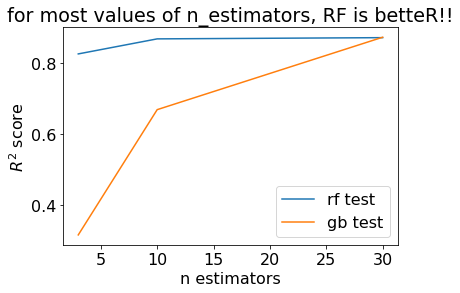

In [44]:
nmax = 3

# plt.plot(n_estimators_values[:nmax], score_rf_train[:nmax], label="rf train")
plt.plot(n_estimators_values[:nmax], score_rf_test[:nmax],  label="rf test")
# plt.plot(n_estimators_values[:nmax], score_gb_train[:nmax], label="gb train")
plt.plot(n_estimators_values[:nmax], score_gb_test[:nmax],  label="gb test")
plt.xlabel("n estimators");
plt.ylabel("$R^2$ score");
plt.legend();
plt.title("for most values of n_estimators, RF is betteR!!");

#### GB better than RF

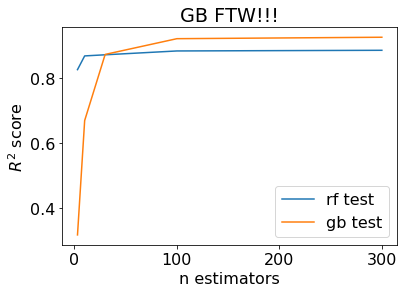

In [61]:
# plt.plot(n_estimators_values, score_rf_train, label="rf train")
plt.plot(n_estimators_values, score_rf_test,  label="rf test")
# plt.ylabel("$R^2$ score");
# plt.legend();
# plt.subplot(2,1,2)
# plt.plot(n_estimators_values, score_gb_train, label="gb train")
plt.plot(n_estimators_values, score_gb_test,  label="gb test")
plt.xlabel("n estimators");
plt.ylabel("$R^2$ score");
plt.legend();
plt.title("GB FTW!!!");

#### Equally good

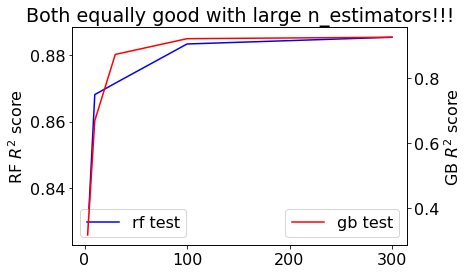

In [58]:
# plt.plot(n_estimators_values, score_rf_train, label="rf train")
plt.plot(n_estimators_values, score_rf_test, 'b', label="rf test")
plt.ylabel("RF $R^2$ score");
plt.legend(loc="lower left");
plt.twinx()
# plt.plot(n_estimators_values, score_gb_train, label="gb train")
plt.plot(n_estimators_values, score_gb_test, 'r', label="gb test")
plt.xlabel("n estimators");
plt.ylabel("GB $R^2$ score");
plt.legend();
plt.title("Both equally good with large n_estimators!!!");